In this notebook the target spectra of Atlantic cod, polar cod and a mix is extract by single echo detection (SED), SED within tracks and average of tarcks. Includes plot comparisons of the different the target spectra.
Based on code by Chelsey McGowan-Yallop


In [2]:
import time
import os.path
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from tenacity import retry, stop_after_attempt
import glob

import sys, errno  


In [3]:

palette = sns.color_palette('colorblind')
plt.style.use(['seaborn-colorblind'])
plt.rc('font', family='Arial')
SMALL_SIZE = 12
BIGGER_SIZE = 14
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.rcParams['xtick.direction'] = 'inout'
plt.rcParams['ytick.direction'] = 'inout'
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 1

savefigs_path = 'C:/Users/mbd/OneDrive - Akvaplan-niva AS/PhD-APN/ChaptersandExperiments/AZKABAN-fish/'

In [7]:
# -- USER-DETERMINED PARAMETERS -----------------------------------------------
path = 'G:/Nya-AZKABAN/AZKABAN-fish2022/'


# .CSV FILES FROM ECHOVIEW
ac_SED_path = path+"AtlanticCod_SED.csv" # Path to Echoview TS(f) file
ac_trackavg_path = path+"AtlanticCod_trackavg.csv" # Path to Echoview TS(f) file
ac_trackSED_path = path+"AtlanticCod_trackSED.csv" # Path to Echoview TS(f) file

pc_SED_path = path+"PolarCod_SED.csv" # Path to Echoview TS(f) file
pc_trackavg_path = path+"PolarCod_trackavg.csv" # Path to Echoview TS(f) file
pc_trackSED_path = path+"PolarCod_trackSED.csv" # Path to Echoview TS(f) file

fm_SED_path = path+"FishMix_SED.csv" # Path to Echoview TS(f) file
fm_trackavg_path = path+"FishMix_trackavg.csv" # Path to Echoview TS(f) file
fm_trackSED_path = path+"FishMix_trackSED.csv" # Path to Echoview TS(f) file

min_range = 1.0 # Apply min range (m) to targets, else None
max_range = 7.0 # Apply max range (m) to targets, else None


In [8]:
def tsf_import(file_path):

    """
    This function imports wideband frequency response .csv files exported from
    Echoview and performs some basic housekeeping.
    
    PARAMETERS:
        file_path: Path to wideband frequency response .csv file from Echoview.
        
    RETURNS:
        df: Pandas dataframe.
    """
    
    def get_datetime(df, avg_flag):
        """
        Convert Echoview timestamps in imported .csv to datetime.
        """
        if avg_flag:
            df['Ping_microseconds_start'] = df.Ping_millisecond_start * 1000
            df['Ping_microseconds_start'] = [timedelta(microseconds = i) for i in df['Ping_microseconds_start']]
            df['Datetime'] = df['Ping_date_start_Ping_time_start'] + df['Ping_microseconds_start']
            df.drop(columns=['Ping_date_start_Ping_time_start',
                             'Ping_millisecond_start',
                             'Ping_microseconds_start'], 
                    inplace=True)
        
        else:
            df['Ping_microseconds'] = df.Ping_milliseconds * 1000
            df['Ping_microseconds'] = [timedelta(microseconds = i) for i in df['Ping_microseconds']]
            df['Datetime'] = df['Ping_date_Ping_time'] + df['Ping_microseconds']
            df.drop(columns=['Ping_date_Ping_time',
                             'Ping_milliseconds',
                             'Ping_microseconds'],
                    inplace=True)
        
        return df
    
    if "trackavg.csv" in file_path:
        parse_cols = ['Ping_date_start', 'Ping_time_start']
        ind_col = None
        avg_flag = True
    else:
        parse_cols = ['Ping_date', 'Ping_time']
        ind_col = 'Target_index'
        avg_flag = False
        
    
    transposed_path = file_path[:-4] + '_transposed.csv'
    if os.path.isfile(transposed_path) == True:
        df = pd.read_csv(transposed_path,
                         index_col=ind_col,
                         skiprows=1,
                         skipfooter=2,
                         engine='python',
                         parse_dates=[parse_cols])
    else:
        df = pd.read_csv(file_path, low_memory=False).T
        file_path = transposed_path
        df.to_csv(path_or_buf=file_path)
        print('A transposed TS(f) file was created at: \n' + str(file_path))    
        df = pd.read_csv(file_path,
                         index_col=ind_col,
                         skiprows=1,
                         skipfooter=2,
                         engine='python',
                         parse_dates=[parse_cols])
    
    df = get_datetime(df, avg_flag)
    
    return df

## Create Target Strength dataframes

In [9]:
# Atlantic cod
acSED_df = tsf_import(ac_SED_path)
actrackSED_df = tsf_import(ac_trackSED_path)
actrackavg_df = tsf_import(ac_trackavg_path)

# Polar cod
pcSED_df = tsf_import(pc_SED_path)
pctrackSED_df = tsf_import(pc_trackSED_path)
pctrackavg_df = tsf_import(pc_trackavg_path)

# Fish Mix
fmSED_df = tsf_import(fm_SED_path)
fmtrackSED_df = tsf_import(fm_trackSED_path)
fmtrackavg_df = tsf_import(fm_trackavg_path)

### extract TS(f) components

In [10]:
# Atlantic cod
acSED = acSED_df.iloc[:,3:-1]
acSED = acSED.astype('float64')
acSED['Species'] = 'Atlantic cod'

actrackSED = actrackSED_df.iloc[:,4:-1]
actrackSED = actrackSED.astype('float64')
actrackSED['Species'] = 'Atlantic cod'

actrackavg = actrackavg_df.iloc[:,12:-1]
actrackavg = actrackavg.astype('float64')
actrackavg['Species'] = 'Atlantic cod'

# Polar cod
pcSED = pcSED_df.iloc[:,3:-1]
pcSED = pcSED.astype('float64')
pcSED['Species'] = 'Polar cod'

pctrackSED = pctrackSED_df.iloc[:,4:-1]
pctrackSED = pctrackSED.astype('float64')
pctrackSED['Species'] = 'Polar cod'

pctrackavg = pctrackavg_df.iloc[:,12:-1]
pctrackavg = pctrackavg.astype('float64')
pctrackavg['Species'] = 'Polar cod'
fmSED = fmSED_df.iloc[:,3:-1]
fmSED = fmSED.astype('float64')

#Fish Mix
fmtrackSED = fmtrackSED_df.iloc[:,4:-1]
fmtrackSED = fmtrackSED.astype('float64')

fmtrackavg = fmtrackavg_df.iloc[:,12:-1]
fmtrackavg = fmtrackavg.astype('float64')

In [11]:
# Combine labels datasets together
single_SED = pd.concat([acSED,pcSED])
single_SED = single_SED.reset_index(drop='Target_index')
single_trackSED = pd.concat([actrackSED,pctrackSED])
single_trackSED = single_trackSED.reset_index(drop='Target_index')
single_trackavg = pd.concat([actrackavg,pctrackavg])
single_trackavg = single_trackavg.reset_index(drop='Target_index')

In [12]:
# Write to pickle to open on Stokes
single_SED.to_pickle(path+'single_SED_df.pkl')
single_trackSED.to_pickle(path+'single_trackSED_df.pkl')
single_trackavg.to_pickle(path+'single_trackavg_df.pkl')

fmSED.to_pickle(path+'fm_SED_df.pkl')
fmtrackSED.to_pickle(path+'fm_trackSED_df.pkl')
fmtrackavg.to_pickle(path+'fm_trackavg_df.pkl')

# Shorten to 10 000 from each fish

In [13]:
acSED.iloc[0:1000]

,90.000,90.500,91.000,91.500,92.000,92.500,93.000,93.500,94.000,94.500,...,166.000,166.500,167.000,167.500,168.000,168.500,169.000,169.500,170.000,Species
Target_index,,,,,,,,,,,,,,,,,,,,,
0,-31.915427,-32.438779,-32.639425,-32.373674,-32.181812,-32.299312,-32.761376,-33.438595,-34.171194,-34.826937,...,-46.172522,-46.564779,-47.031860,-47.691934,-48.610345,-49.751749,-50.981897,-51.929721,-52.222216,Atlantic cod
1,-22.308761,-24.095614,-26.588792,-28.852032,-31.036601,-33.490477,-34.878346,-33.993306,-33.408257,-34.256870,...,-43.314092,-43.941237,-44.254829,-41.246798,-38.913973,-38.136331,-36.739971,-34.739819,-34.256446,Atlantic cod
2,-36.114666,-32.214917,-30.416021,-29.992647,-31.018295,-33.340891,-35.952621,-36.339681,-35.130569,-34.385286,...,-50.671039,-56.296144,-67.409275,-63.254305,-61.576541,-63.948518,-64.609738,-65.216180,-69.957655,Atlantic cod
3,-38.280398,-36.966869,-36.781604,-37.251602,-38.400912,-39.620860,-39.941762,-39.342528,-38.667696,-38.411133,...,-61.052424,-64.412874,-66.698775,-64.882859,-60.389657,-56.257941,-53.426689,-51.985144,-51.928260,Atlantic cod
4,-36.151157,-36.138085,-36.823339,-37.760591,-38.726831,-39.061169,-38.784957,-38.381079,-38.155103,-38.200958,...,-60.422621,-64.317494,-60.951879,-58.635508,-57.245403,-54.419167,-51.911909,-51.049755,-51.767891,Atlantic cod
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-31.939922,-31.301444,-29.236474,-30.061914,-34.851306,-45.013902,-36.314014,-33.287619,-33.572464,-36.615019,...,-42.415520,-45.079609,-43.555086,-46.252826,-47.750266,-38.609019,-34.922559,-34.739021,-39.005740,Atlantic cod
996,-60.678579,-56.268054,-52.639955,-49.637780,-47.502114,-46.332147,-46.149861,-46.717390,-47.630196,-48.419991,...,-40.430418,-41.509595,-42.812716,-44.442601,-46.351459,-48.242027,-49.790717,-50.854742,-51.331197,Atlantic cod
997,-62.686150,-60.600977,-56.241276,-51.359720,-47.874268,-46.219593,-46.074111,-46.849570,-47.868538,-48.600460,...,-41.814013,-42.930501,-44.272588,-45.866784,-47.666316,-49.503780,-51.124514,-52.326830,-53.002068,Atlantic cod


In [ ]:
ac

In [14]:
# Write to pickle to open on Stokes
n=10000
single_SED_20k = pd.concat([acSED.iloc[0:n],pcSED.iloc[0:n]])
single_SED_20k = single_SED.reset_index(drop='Target_index')
single_trackSED_20k = pd.concat([actrackSED.iloc[0:n],pctrackSED.iloc[0:n]])
single_trackSED_20k = single_trackSED.reset_index(drop='Target_index')
single_trackavg_20k = pd.concat([actrackavg.iloc[0:n],pctrackavg.iloc[0:n]])
single_trackavg_20k = single_trackavg.reset_index(drop='Target_index')

single_SED_20k.to_pickle(path+'single_SED_20k_df.pkl')
single_trackSED_20k.to_pickle(path+'single_trackSED_20k_df.pkl')
single_trackavg_20k.to_pickle(path+'single_trackavg_20k_df.pkl')


### plot comparison of all the nine datasets. Target spectra of Atlantic cod, polar cod and fish mix with SED, SED from tracks and track averages

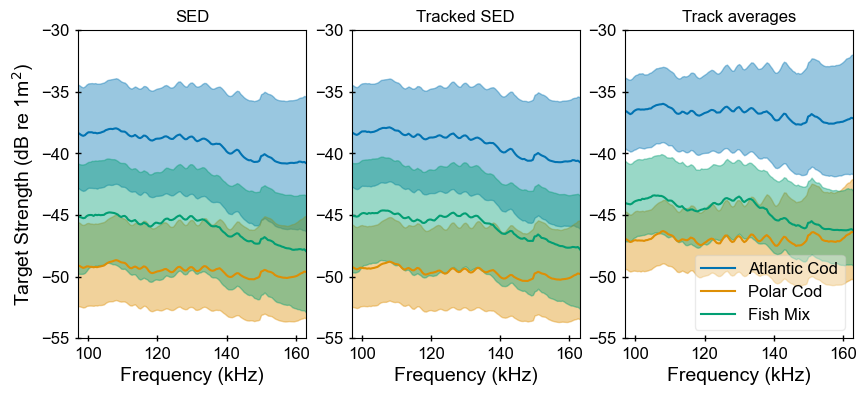

In [8]:
freqs = np.linspace(90,170,161)

fig, ax = plt.subplots(1,3, figsize=(10,4))
axes = ax.flatten()
spectra = [acSED ,actrackSED, actrackavg, pcSED, pctrackSED, pctrackavg, fmSED, fmtrackSED, fmtrackavg]

for i in range(len(spectra)):
    ax_i = [0,1,2,0,1,2,0,1,2]
    c = [0,0,0,1,1,1,2,2,2]
    label_i=['Atlantic Cod','Atlantic Cod','Atlantic Cod', 'Polar Cod','Polar Cod','Polar Cod', 'Fish Mix', 'Fish Mix', 'Fish Mix']
    axes[ax_i[i]].plot(freqs,
            spectra[i].median(),
            label=label_i[i],
            color=palette[c[i]])

    axes[ax_i[i]].fill_between(freqs,
                    spectra[i].quantile(q=0.25),
                    spectra[i].quantile(q=0.75),
                    alpha=0.4,
                    color=palette[c[i]])
    axes[ax_i[i]].set_xlim([97,163]) # See calibration_compare.ipynb for selected edge cutoffs
    axes[ax_i[i]].set_ylim([-55,-30])
    axes[ax_i[i]].set_xlabel('Frequency (kHz)')
axes[0].set_ylabel('Target Strength (dB re 1m$^2$)')
axes[0].set_title('SED')
axes[1].set_title('Tracked SED')
axes[2].set_title('Track averages')
axes[2].legend(loc='lower right', framealpha=0.4)

In [16]:
pcSED.iloc[:, :] 

,90.000,90.500,91.000,91.500,92.000,92.500,93.000,93.500,94.000,94.500,...,165.500,166.000,166.500,167.000,167.500,168.000,168.500,169.000,169.500,170.000
Target_index,,,,,,,,,,,,,,,,,,,,,
0,-41.913323,-43.607112,-45.030356,-45.326763,-44.756386,-44.110466,-43.768891,-43.747728,-43.958671,-44.321992,...,-45.185273,-45.442705,-45.801547,-46.340439,-47.071224,-47.892877,-48.611834,-49.063880,-49.264606,-49.440386
1,-44.701978,-45.024713,-45.601767,-45.624781,-45.945615,-47.156290,-49.164443,-51.360439,-53.018983,-53.964591,...,-48.584869,-49.696674,-51.428282,-53.853308,-56.848627,-59.683178,-60.854698,-60.654022,-61.253598,-64.351420
2,-54.644166,-49.749988,-46.565052,-44.419048,-43.469312,-43.815366,-45.453692,-48.392515,-53.189481,-62.656721,...,-49.686540,-51.494346,-53.350163,-54.417697,-54.913732,-55.959761,-58.204181,-61.942420,-68.353881,-108.449340
3,-42.207367,-47.058515,-38.843726,-37.923729,-41.174301,-49.667898,-55.477267,-51.851688,-49.160969,-46.186974,...,-47.018610,-46.071339,-45.732888,-43.974978,-42.739815,-44.063907,-48.855272,-50.800083,-48.834115,-49.839573
4,-38.931586,-36.432180,-38.840735,-46.369434,-40.904762,-39.047118,-41.956591,-44.346094,-41.418566,-41.458021,...,-38.012220,-36.425563,-34.214291,-36.228282,-40.189493,-35.201685,-33.274070,-35.332710,-36.699875,-33.385915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205004,-43.428381,-47.337545,-53.099750,-47.236015,-45.038487,-44.986383,-45.365335,-45.811439,-46.734956,-48.228590,...,-47.228845,-49.768585,-57.370430,-58.823452,-53.348696,-53.741495,-58.797557,-75.589749,-57.331971,-51.863021
205005,-47.534607,-49.736144,-50.076658,-47.506362,-44.724849,-43.356612,-43.462671,-44.669805,-46.480210,-48.124215,...,-49.812486,-49.982477,-50.613662,-51.372274,-51.761679,-51.458862,-50.708468,-50.218049,-50.623623,-52.220575
205006,-37.882461,-38.120351,-46.292688,-42.581029,-38.830360,-40.940112,-50.859239,-51.381660,-45.869506,-46.734522,...,-52.017560,-56.986298,-55.957259,-53.057739,-58.682203,-57.506721,-48.854398,-48.107077,-53.782786,-50.762024
